In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy

# Data analysis with time optimization. Compare with "data_analysis.iynb"

In [2]:
run_results = joblib.load("../results/run_2024-01-05_17:35:03_results.job")
run_model = joblib.load("../results/run_2024-01-05_17:35:03_model.job")

In [3]:
true_parameters = game.true_pars
# help(run_model)

In [4]:
run_results

Run(
  iteration=i32[500],
  key=u32[500,2],
  weights=f32[500,2000],
  particles_locations=f32[500,2000,4],
  max_iterations=i32[500],
  min_iterations=i32[500],
  std_threshold=f32[500],
  cov_array=f32[500,4000,4,4],
  estimates_array=f32[500,4000,4]
)

In [5]:
final_cov_matrix = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.cov_array, run_results.iteration
)

final_cov_norm = jax.vmap(jnp.linalg.norm, in_axes=(0))(final_cov_matrix)

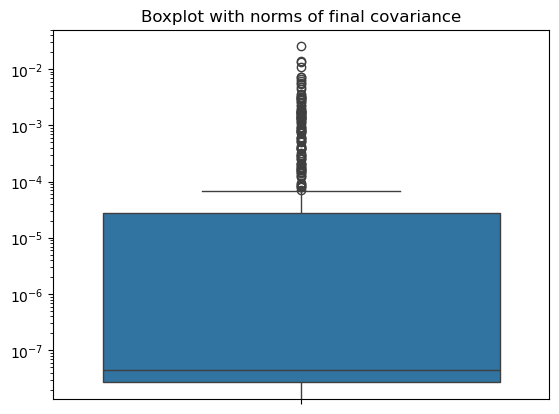

In [6]:
sns.boxplot(y=final_cov_norm)
plt.yscale("log")
plt.title("Boxplot with norms of final covariance")
plt.show()

In [7]:
final_estimates = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.estimates_array, run_results.iteration
)

In [8]:
df = pd.DataFrame(final_estimates, columns=["par1", "par2", "par3", "par4"])

df_true_pars = pd.DataFrame(
    true_parameters[np.newaxis, :], columns=["par1", "par2", "par3", "par4"]
)

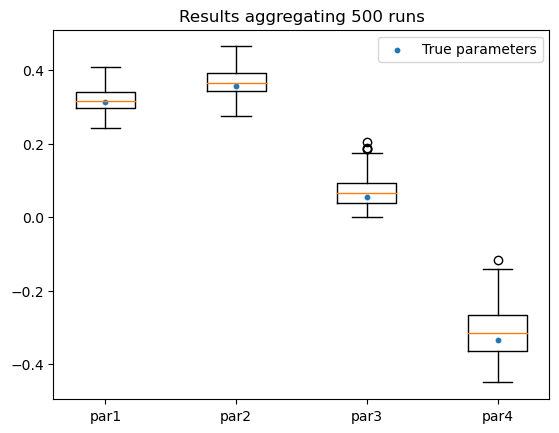

In [9]:
plt.style.use("default")
colnames = ["par1", "par2", "par3", "par4"]
plt.boxplot(df, labels=colnames, positions=range(len(df.columns)))
plt.scatter(
    colnames, true_parameters, label="True parameters", marker="o", s=10
)
# plt.plot(df_true_pars)
plt.title("Results aggregating 500 runs")
plt.legend()
plt.show()

In [10]:
number_of_samples = 500

In [11]:
from scipy.stats import bootstrap

mean = np.array(final_estimates.mean(axis=0))
standard_error_mean = np.array(final_estimates).std(axis=0) / np.sqrt(
    number_of_samples
)

median = np.median(final_estimates, axis=0)


confidence_interval_mean = bootstrap(
    (final_estimates,),
    np.mean,
    confidence_level=0.95,
    random_state=1,
    method="percentile",
    axis=0,
)
bootstrap_ci = bootstrap(
    (final_estimates,),
    np.median,
    confidence_level=0.95,
    random_state=1,
    method="percentile",
    axis=0,
)
standard_error_median = (
    bootstrap_ci.confidence_interval[1] - bootstrap_ci.confidence_interval[0]
) / 3.92

In [12]:
for i in range(4):
    print(f"Parameter {str(i)}:  ")

    print(f"True value: {true_parameters[i]} ")
    print("\n")
    print(f"Mean estimate: {mean[i]:.5f} pm {standard_error_mean[i]:.5f}")
    print(
        f"Median estimate: {median[i]:.5f} pm {standard_error_median[i]:.5f}"
    )
    print("---")
    print(
        f"0.95 Confidence Interval for mean: {confidence_interval_mean.confidence_interval[0][ i]:.5f}, {confidence_interval_mean.confidence_interval[1][  i]:.5f} "
    )
    print(
        f"0.95 Confidence Interval for median: {bootstrap_ci.confidence_interval[0][ i]:.5f}, {bootstrap_ci.confidence_interval[1][  i]:.5f} "
    )
    print("\n")

Parameter 0:  
True value: 0.3142159879207611 


Mean estimate: 0.31969 pm 0.00142
Median estimate: 0.31726 pm 0.00196
---
0.95 Confidence Interval for mean: 0.31696, 0.32249 
0.95 Confidence Interval for median: 0.31407, 0.32175 


Parameter 1:  
True value: 0.35833001136779785 


Mean estimate: 0.36659 pm 0.00159
Median estimate: 0.36492 pm 0.00207
---
0.95 Confidence Interval for mean: 0.36354, 0.36972 
0.95 Confidence Interval for median: 0.36154, 0.36966 


Parameter 2:  
True value: 0.05385100096464157 


Mean estimate: 0.06966 pm 0.00182
Median estimate: 0.06656 pm 0.00229
---
0.95 Confidence Interval for mean: 0.06615, 0.07322 
0.95 Confidence Interval for median: 0.06311, 0.07209 


Parameter 3:  
True value: -0.3336949944496155 


Mean estimate: -0.31195 pm 0.00293
Median estimate: -0.31486 pm 0.00387
---
0.95 Confidence Interval for mean: -0.31765, -0.30623 
0.95 Confidence Interval for median: -0.32015, -0.30497 




<ErrorbarContainer object of 3 artists>

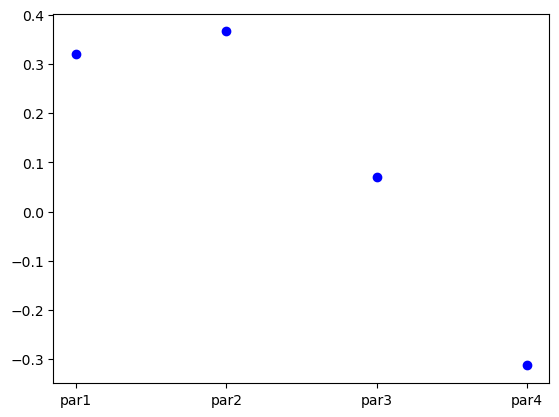

In [13]:
# plt.plot(colnames, mean, marker="o", color="b", linestyle='none')
plt.errorbar(x=colnames, y=mean, yerr=standard_error_mean, fmt="bo")

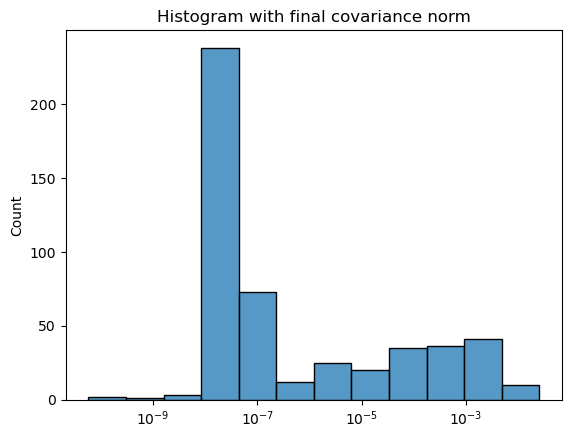

In [14]:
sns.histplot(final_cov_norm, log_scale=True)
plt.title("Histogram with final covariance norm")
plt.show()

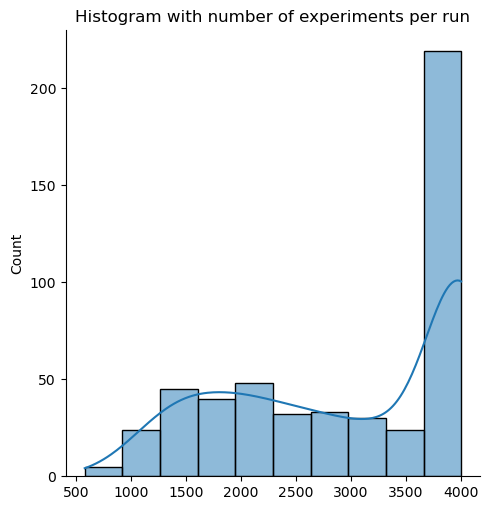

In [15]:
sns.displot(run_results.iteration, kde=True)
plt.title("Histogram with number of experiments per run")
plt.show()

# Plots with number of iterations in x axis

In [16]:
iters = np.arange(0, 4000)

In [17]:
def f_to_replace_with_nan(covariances, iteration):
    arr = np.array(covariances)
    arr[iteration + 1 :] = np.nan
    return arr

In [18]:
np_cov_arr = np.array(run_results.cov_array)
np_estimates_arr = np.array(run_results.estimates_array)
np_iter = np.array(run_results.iteration)

In [19]:
for i in range(500):
    np_cov_arr[i] = f_to_replace_with_nan(np_cov_arr[i], np_iter[i])
    np_estimates_arr[i] = f_to_replace_with_nan(
        np_estimates_arr[i], np_iter[i]
    )

In [20]:
all_runs_diff_squared = (true_parameters - np_estimates_arr) ** 2

mse_array_mean = np.nanmean(np.nanmean(all_runs_diff_squared, axis=2), axis=0)
mse_array_median = np.nanmedian(
    np.nanmean(all_runs_diff_squared, axis=2), axis=0
)

mse_array_std = np.nanstd(np.nanmean(all_runs_diff_squared, axis=2), axis=0)

/tmp/ipykernel_590692/3461045166.py:3: RuntimeWarning: Mean of empty slice
  mse_array_mean = np.nanmean(np.nanmean(all_runs_diff_squared, axis=2), axis=0)
/tmp/ipykernel_590692/3461045166.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(all_runs_diff_squared, axis=2), axis=0
/tmp/ipykernel_590692/3461045166.py:8: RuntimeWarning: Mean of empty slice
  mse_array_std = np.nanstd(np.nanmean(all_runs_diff_squared, axis=2), axis=0)


In [21]:
def fun_to_fit(iteration, a, b):
    return -a * iteration**b


fitting_estimates_mse, fitting_covariances_mse = scipy.optimize.curve_fit(
    fun_to_fit, iters[1:], mse_array_mean[1:]
)

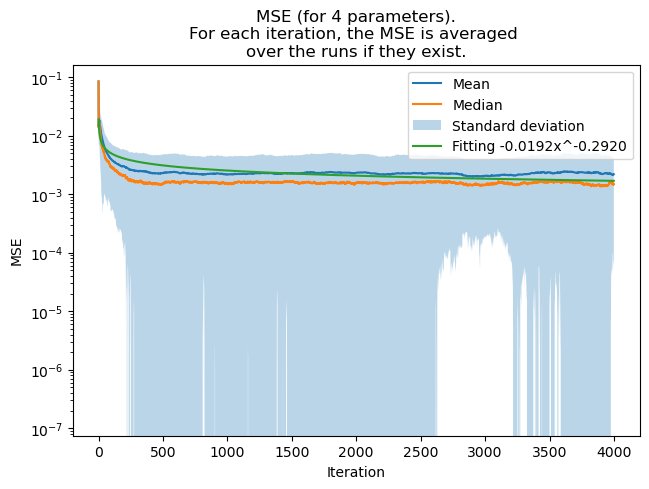

In [22]:
plt.plot(iters, mse_array_mean, label="Mean")
plt.plot(iters, mse_array_median, label="Median")

plt.fill_between(
    x=iters,
    y1=mse_array_mean - mse_array_std,
    y2=mse_array_mean + mse_array_std,
    alpha=0.3,
    label="Standard deviation",
)

plt.plot(
    iters[1:],
    fun_to_fit(iters[1:], *fitting_estimates_mse),
    label=f"Fitting {fitting_estimates_mse[0]:.4f}x^{fitting_estimates_mse[1]:.4f}",
)
plt.yscale("log")

plt.legend()
plt.title(
    "MSE (for 4 parameters).\nFor each iteration, the MSE is averaged \nover the runs if they exist."
)
plt.tight_layout()
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

In [23]:
@jit
def jeje():
    re = []
    for i in range(500):
        re.append(vmap(jnp.linalg.norm, 0)(np_cov_arr[i]))
    return re

In [24]:
re = jeje()
re = np.array(re)

In [25]:
mean_per_iteration = np.nanmean(re, axis=0)
median_per_iteration = np.nanmedian(re, axis=0)
std_per_iteration = np.nanstd(re, axis=0)

In [26]:



def fun_to_fit(iteration, a, b):
    return -a * iteration**b


fitting_estimates_cov, fitting_covariances_cov = scipy.optimize.curve_fit(
    fun_to_fit, iters[1:], mean_per_iteration[1:]
)

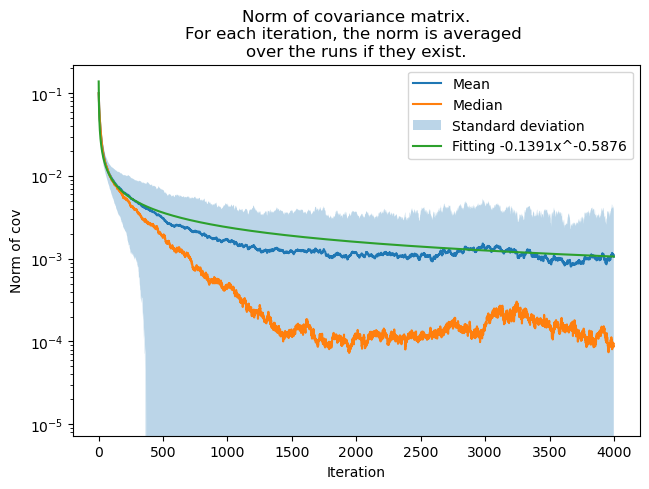

In [27]:
plt.plot(iters[1:], mean_per_iteration[1:], label="Mean")
plt.plot(iters[1:], median_per_iteration[1:], label="Median")
plt.fill_between(
    x=iters,
    y1=mean_per_iteration - std_per_iteration,
    y2=mean_per_iteration + std_per_iteration,
    alpha=0.3,
    label="Standard deviation",
)


plt.plot(
    iters[1:],
    fun_to_fit(iters[1:], *fitting_estimates_cov),
    label=f"Fitting {fitting_estimates_cov[0]:.4f}x^{fitting_estimates_cov[1]:.4f}",
)


plt.yscale("log")
plt.legend()
plt.title(
    "Norm of covariance matrix.\nFor each iteration, the norm is averaged \nover the runs if they exist."
)
plt.tight_layout()
plt.xlabel("Iteration")
plt.ylabel("Norm of cov")


plt.show()